In [11]:
# Import modules
import numpy as np # Numerical analysis
import pandas as pd # Dataset Exploration & Analysis
import matplotlib.pyplot as plt # VIsualization
import seaborn as sns # Enhanced plots


In [12]:
# Ensure consistent outputs for reproducibility
np.random.seed(42)


In [13]:
# Generate a date range spanning 3 months with hourly intervals
date_range = pd.date_range(start="2024-01-01", end="2024-11-30 23:00", freq="h")
n_hours = len(date_range)  # Total number of hours in this period


In [14]:
# === Temporal Features ===
# Create a DataFrame to store timestamps and derived time-related features
df = pd.DataFrame({
    "timestamp": date_range,
    "hour": date_range.hour,  # Extract hour of the day (0-23)
    "day_of_week": date_range.dayofweek,  # Monday=0, Sunday=6
    "month": date_range.month,  # Month of the year
    "holiday": np.random.choice([0, 1], size=n_hours, p=[0.95, 0.05])  # Randomly mark 5% of days as holidays
})

In [15]:
# === Weather Features ===
# Temperature follows both a daily cycle (sinusoidal) and a seasonal cycle
daily_cycle = 5 * np.sin(2 * np.pi * df["hour"] / 24)  # Daily temperature variation
seasonal_cycle = 10 * np.sin(2 * np.pi * (date_range.dayofyear - 1) / 365)  # Seasonal temperature variation

In [16]:
# Base temperature fluctuates around 20°C, modified by daily & seasonal patterns
temperature_base = 20 + daily_cycle + seasonal_cycle
df["temperature"] = temperature_base + np.random.normal(0, 2, n_hours)  # Adding noise

In [17]:
# Cloud cover changes smoothly over time using an autoregressive model
cloud_cover = np.zeros(n_hours)
cloud_cover[0] = np.random.uniform(0, 1)  # Initialize with a random value
for i in range(1, n_hours):
    cloud_cover[i] = cloud_cover[i-1] * 0.9 + np.random.uniform(0, 0.1)  # Smoothed transition
df["cloud_cover"] = np.clip(cloud_cover, 0, 1)  # Ensure values stay between 0 and 1

In [18]:
# === Solar Power Generation ===
# Solar irradiance follows a sinusoidal pattern during daylight hours
solar_irradiance = np.where(
    (df["hour"] >= 6) & (df["hour"] <= 18),  # Sunlight hours
    1000 * np.sin(np.pi * (df["hour"] - 6) / 12),  # Peak around noon
    0  # No sunlight at night
)
panel_efficiency= np.random.uniform(0.18, 0.22, n_hours)  # Different per hour


In [19]:
# Compute the raw solar output
solar_output = solar_irradiance * panel_efficiency * 100 * np.sin(np.pi * (df["hour"] - 8) / 9)

# Only consider daytime values for rescaling
daytime_mask = (df["hour"] >= 8) & (df["hour"] <= 17)

# Get the max value in the current solar output (daytime only)
max_actual_solar = solar_output[daytime_mask].max()

# Scale the entire solar output to make sure the max value is 120 kW
df["solar_pv_output"] = np.where(
    daytime_mask,
    solar_output * (120 / max_actual_solar),  # Rescale everything proportionally
    0,  # Nighttime remains 0
)

In [21]:
# === Load Demand Estimation ===
# Base load is higher during business hours (8 AM - 8 PM) and lower at night
df["load_demand"] = np.where(
    (df["hour"] >= 8) & (df["hour"] <= 20),
    100 * (1 - 0.2 * (df["day_of_week"] >= 5)),  # Weekend reduction
    30 + 10 * (df["hour"] < 5)  # Higher demand early morning due to heating
)

In [22]:

# Modify demand based on temperature (higher temp increases cooling demand)
df["load_demand"] += np.exp((df["temperature"] - 25) / 10)

In [23]:
# Add slight random variations to simulate real-world fluctuations
df["load_demand"] *= (1 + np.random.normal(0, 0.05, n_hours))

In [24]:
# === Battery Storage & Diesel Generator Simulation ===
# Battery parameters
battery_capacity = 200  # Max storage capacity in kWh
max_charge_rate = 50  # Max charge/discharge rate per hour
battery_level = battery_capacity * 0.5  # Start with 50% charge

In [25]:
# Initialize columns for energy storage system
df["battery_charge"] = np.zeros(n_hours)  # Energy charged into battery
df["battery_discharge"] = np.zeros(n_hours)  # Energy drawn from battery
df["battery_soc"] = np.zeros(n_hours)  # Battery state of charge (%)
df["diesel_generator_usage"] = np.zeros(n_hours)  # Diesel backup (if needed)

In [26]:
# Simulate battery operation over time
for i in range(1, n_hours):
    net_demand = df.at[i, "load_demand"] - df.at[i, "solar_pv_output"]  # Net energy required

    if net_demand > 0:  # Demand exceeds solar supply (deficit)
        if battery_level > 0:  # Battery available to discharge
            discharge = min(net_demand, max_charge_rate, battery_level)
            df.at[i, "battery_discharge"] = discharge
            battery_level -= discharge
        else:  # No battery left, fallback to diesel generator
            df.at[i, "diesel_generator_usage"] = net_demand
    else:  # Excess solar power available (surplus)
        charge = min(-net_demand, max_charge_rate, battery_capacity - battery_level)
        df.at[i, "battery_charge"] = charge
        battery_level += charge

    # Ensure battery stays within 0-100% range
    battery_level = max(0, min(battery_level, battery_capacity))
    df.at[i, "battery_soc"] = (battery_level / battery_capacity) * 100  # Convert to percentage

In [29]:
def plot_energy_trends(df, start_date="2024-01-01", end_date="2024-03-31", sample_size=200):
    """
    Visualizes key energy metrics over a specified period.
    """
    # Ensure timestamp is datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Filter data
    df_filtered = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]
    df_sampled = df_filtered.iloc[:sample_size]

    #print("Filtered Data Preview:")
    #print(df_sampled.head())  # Debugging step

    # If no data, exit function early
    if df_sampled.empty:
        print("⚠️ Warning: No data available for the given date range.")
        return

    fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

    # Solar PV Output
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["solar_pv_output"], ax=axes[0], 
                 label="Solar PV Output", color="goldenrod", legend="full")
    axes[0].set_ylabel("Solar PV (kW)")
    axes[0].legend()

    # Load Demand
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["load_demand"], ax=axes[1], 
                 label="Load Demand", color="darkred", legend="full")
    axes[1].set_ylabel("Load Demand (kW)")
    axes[1].legend()

    # Battery Charge & Discharge
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["battery_charge"], ax=axes[2], 
                 label="Battery Charge", color="green", legend="full")
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["battery_discharge"], ax=axes[2], 
                 label="Battery Discharge", color="blue", legend="full")
    axes[2].set_ylabel("Battery (kW)")
    axes[2].legend()

    # Battery SOC
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["battery_soc"], ax=axes[3], 
                 label="Battery SOC (%)", color="purple", legend="full")
    axes[3].set_ylabel("Battery SOC (%)")
    axes[3].legend()

    # Diesel Generator Usage
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["diesel_generator_usage"], ax=axes[4], 
                 label="Diesel Generator Usage", color="black", legend="full")
    axes[4].set_ylabel("Diesel (kW)")
    axes[4].legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


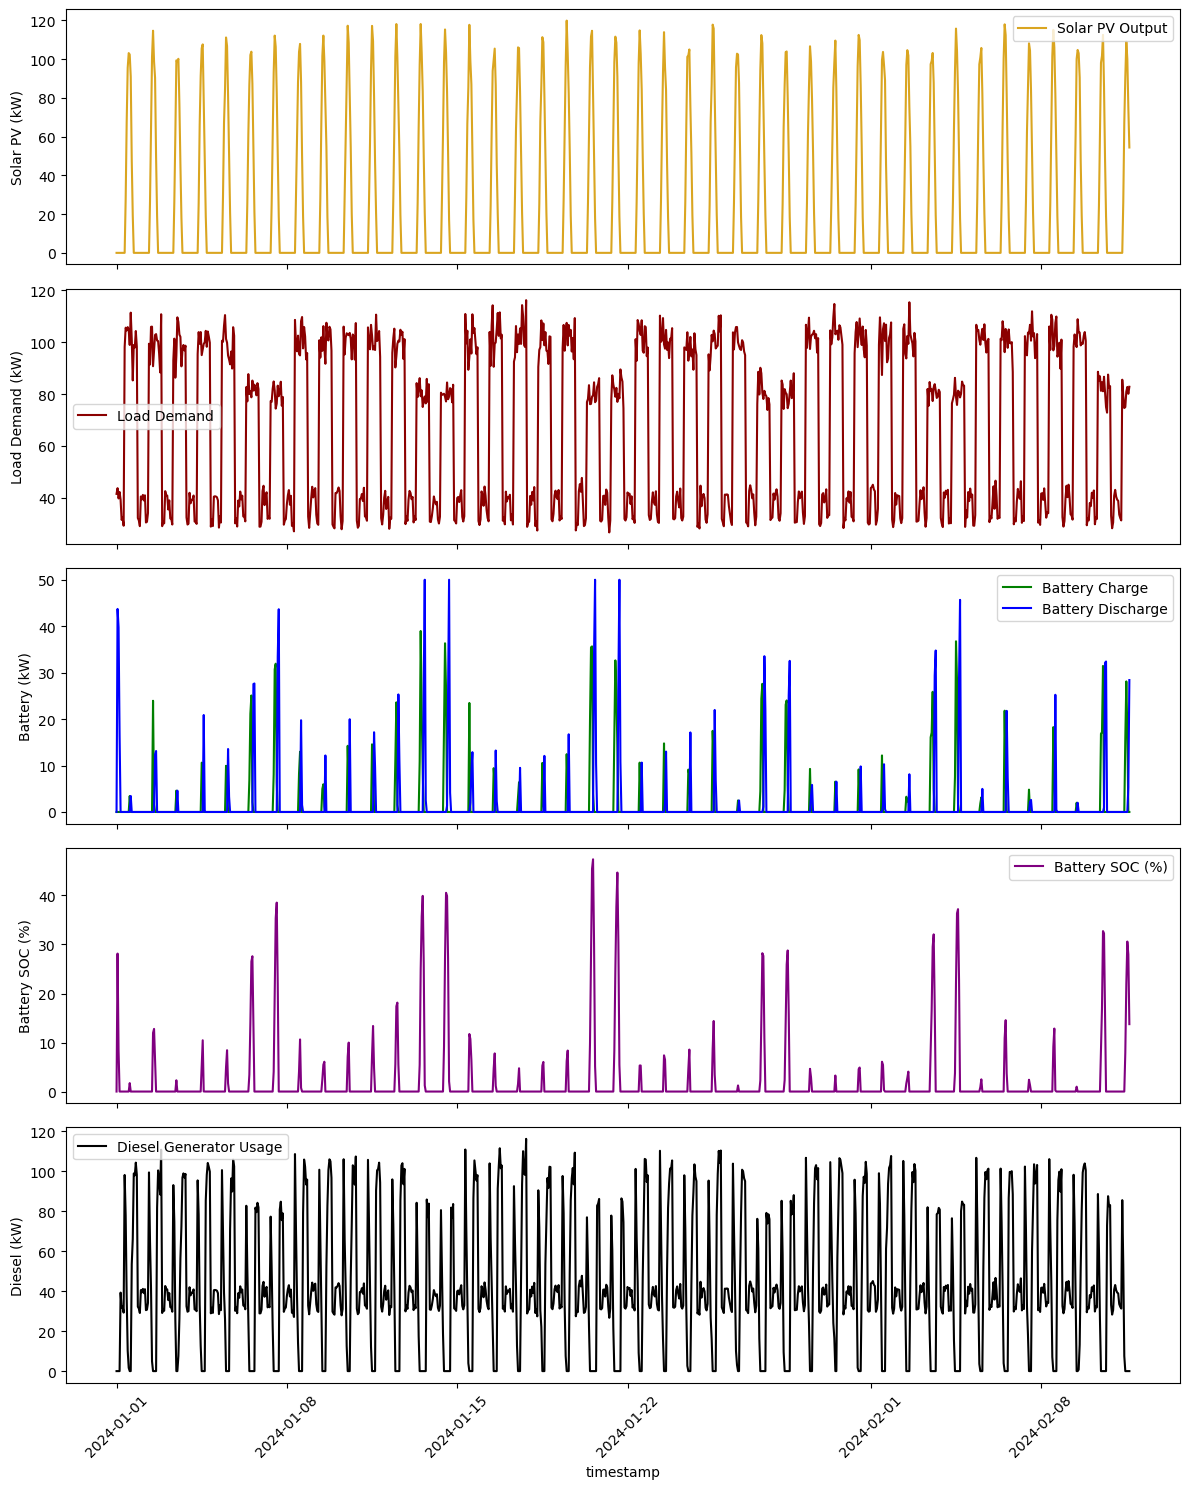

In [30]:
plot_energy_trends(df, sample_size=1000)

In [31]:

def plot_energy_trends(df, start_date="2024-01-01", end_date="2024-03-31", sample_size=200):
    """
    Visualizes key energy metrics with combined graphs.
    """
    # Ensure timestamp is datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Filter data
    df_filtered = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]
    df_sampled = df_filtered.iloc[:sample_size]

    if df_sampled.empty:
        print("⚠️ Warning: No data available for the given date range.")
        return

    plt.figure(figsize=(12, 12))

    # Solar PV Output vs. Load Demand
    plt.subplot(3, 1, 1)
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["solar_pv_output"], label="Solar PV Output", color="goldenrod")
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["load_demand"], label="Load Demand", color="darkred")
    plt.ylabel("Power (kW)")
    plt.title("Solar PV vs. Load Demand")
    plt.legend()
    
    #  Battery Charge & Discharge vs. SOC
    plt.subplot(3, 1, 2)
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["battery_charge"], label="Battery Charge", color="green")
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["battery_discharge"], label="Battery Discharge", color="blue")
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["battery_soc"], label="Battery SOC (%)", color="purple")
    plt.ylabel("Battery (kW / %)")
    plt.title("Battery Charge, Discharge & SOC")
    plt.legend()
    
    #  Diesel Generator Usage vs. Load Demand
    plt.subplot(3, 1, 3)
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["diesel_generator_usage"], label="Diesel Generator Usage", color="black")
    sns.lineplot(x=df_sampled["timestamp"], y=df_sampled["load_demand"], label="Load Demand", color="darkred", linestyle="dashed")
    plt.ylabel("Power (kW)")
    plt.title("Diesel Generator Usage vs. Load Demand")
    plt.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


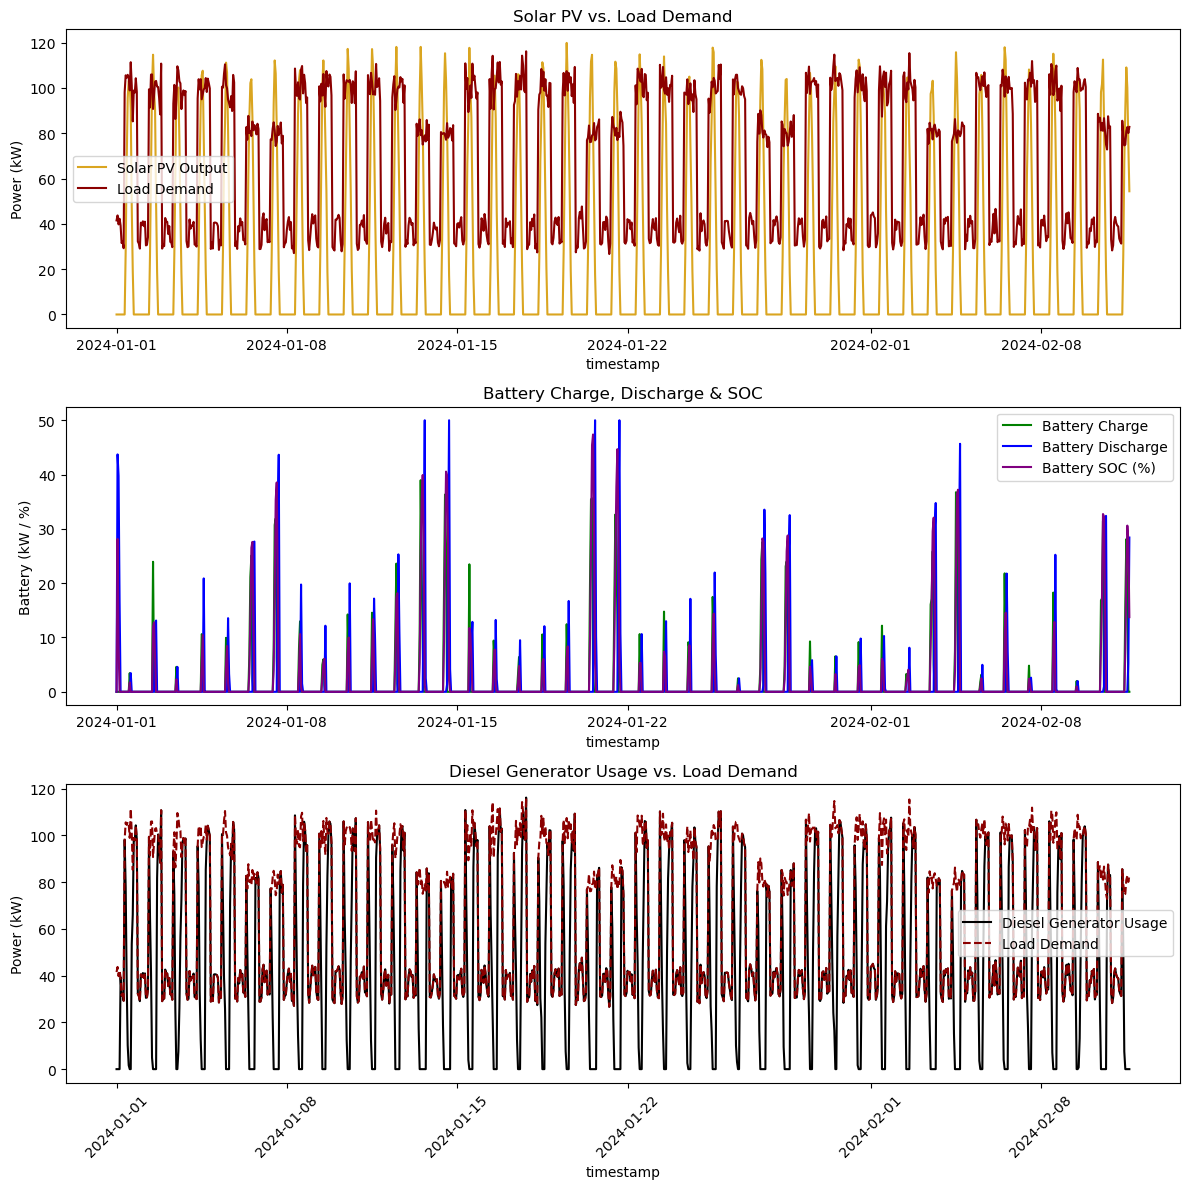

In [32]:
plot_energy_trends(df, sample_size=1000)

In [ ]:

# =======
# Create Temporal moving Averages
# ======

# Shift demand by 1 hour
df["demand_prev_hour"] = df["load_demand"].shift(1)

# Shift demand by 24 hours (same hour previous day)
df["demand_prev_day"] = df["load_demand"].shift(24)

# Rolling averages for smoothing trends
df["demand_rolling_7d"] = df["load_demand"].rolling(window=7*24, min_periods=1).mean()
df["demand_rolling_24h"] = df["load_demand"].rolling(window=24, min_periods=1).mean()

# Fill NaN values (first few rows will have NaN)
df.fillna(method="bfill", inplace=True) 

/tmp/ipykernel_28418/282164066.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)  # Use forward fill if needed


In [ ]:
# Save data to csv file
df.to_csv('generate_energy_data.csv')